In [1]:
from radar import *
from rain import *

import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import seaborn as sbn
import pandas as pd 
import numpy as np
import scipy.stats as st

%matplotlib inline

In [2]:
large_extent = [-82, -80, 34.5, 36]
small_extent = [-81.035000-.01, -80.552222+.01, 35.019722-.01, 35.507778+.01]

fname = '../../data/CHARLOTTE/Maps/new_basin.shp'
basins = list(shpreader.Reader(fname).geometries())

fname = '../../data/CHARLOTTE/Maps/county.shp'
county = list(shpreader.Reader(fname).geometries())

In [3]:
computed = pd.HDFStore('computed.h5')
p = computed['features_buffer0_ratethresh10_minarea20_cont20']
computed.close()

In [4]:
TOP50 = pd.read_csv('../../Paper/TOP50_Events/TOP50_events_Charlotte.csv', parse_dates=[0,1])
c = Radar('charlotte', TOP50.t_begin[0], how='hdf5', store='TOP50.h5', fname='storm_{yyyy}_{mm:02d}_{dd:02d}', make_rate=4)

Exclude features that extend outside of the radar field if we assume they are circular:

In [179]:
#%%timeit 100 loops, best of 3: 12.8 ms per loop
from geopy.distance import vincenty

edges = zip(c.lat[0, 0:140], c.lon[0, 0:140])
edges.extend(zip(c.lat[0:140, 139], c.lon[0:140, 139]))
edges.extend(zip(np.flipud(c.lat[139, 0:140]), np.flipud(c.lon[139, 0:140])))
edges.extend(zip(np.flipud(c.lat[0:140, 0]), np.flipud(c.lon[0:140, 0])))

for it in range(0, 2214):
    for ifeat in range(31):
        if np.isnan(p[it, ifeat, 'centroidY']):
            continue
        center = p[it, ifeat, ['centroidY', 'centroidX']].values
        dist = min([vincenty(center, edge).kilometers for edge in edges])
        r = (p[it, ifeat, ['area']].values/np.pi)**.5
        if r>dist:
            df0 = p[it,:,:]
            for ichar in range(21):
                df0.set_value(p.major_axis[ifeat], p.minor_axis[ichar], np.nan)

In [182]:
ne = [0, 90, 'North East']
se = [90, 180, 'South East']
sw = [-180, -90, 'South West']
nw = [-90, 0, 'North West']
dirs4 = [nw, ne, sw, se]
n = 1
for b in dirs4:
    bool_array = ((p[:,:,'Bearing']>b[0]) & (p[:,:,'Bearing']<b[1]))
    b.append(bool_array)
    b.append(n)
    n+=1

In [386]:
n = [-15, 15, 'North']
ne = [30, 60, 'North East']
e = [75, 105, 'East']
se = [120, 150, 'South East']
s = [165, -165, 'South']
sw = [-150, -120, 'South West']
w = [-105, -75, 'West']
nw = [-60, -30, 'North West']
dirs8 = [nw, n, ne, w, None, e, sw, s, se]
n = 1
for i, b in enumerate(dirs8):
    if i == 4:
        n+=1
        continue
    elif i == 7:
        bool_array = ((p[:,:,'Bearing']>b[0]) | (p[:,:,'Bearing']<b[1])) 
    else:
        bool_array = ((p[:,:,'Bearing']>b[0]) & (p[:,:,'Bearing']<b[1]))
    b.append(bool_array)
    b.append(n)
    n+=1

In [260]:
def get_lon_lat(b, pos=False, neg=False, metrics=['area', 'Intensity0.9', 'Intensity0.25']):
    lon=p[:,:,'centroidX'][b[3]].stack().values
    lat=p[:,:,'centroidY'][b[3]].stack().values
    if pos or neg:
        ifeats = np.where(b[3].values)[0]
        its = np.where(b[3].values)[1]
        j=[]
        dist=[]
        for metric in metrics:
            for ifeat, it in zip(ifeats, its):
                try:
                    nfeat = p[it,ifeat,:].Forecast-1
                    j0 = p[it,ifeat,metric]
                    j1 = p[it+1,nfeat,metric]
                    if np.isnan(j1):
                        j.append(0)
                    else:
                        j.append(j1-j0)
                        dist.append(p[it,ifeat, ['Mean Error Distance']].values)
                except:
                    j.append(0)
        j = np.array(j)
    else:
        return(lon, lat)
    pos_lon = np.concatenate([lon]*len(metrics))[j>0]
    pos_lat = np.concatenate([lat]*len(metrics))[j>0]
    neg_lon = np.concatenate([lon]*len(metrics))[j<0]
    neg_lat = np.concatenate([lat]*len(metrics))[j<0]
    if pos and not neg:
        return(pos_lon, pos_lat)
    elif neg and not pos:
        return(neg_lon, neg_lat, np.mean(dist))
    elif neg and pos:
        return(pos_lon, pos_lat, neg_lon, neg_lat, np.mean(dist))
    

In [261]:
def kde(lon, lat):
    xx, yy = c.lon, c.lat
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([lon, lat])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    return(xx,yy,f)

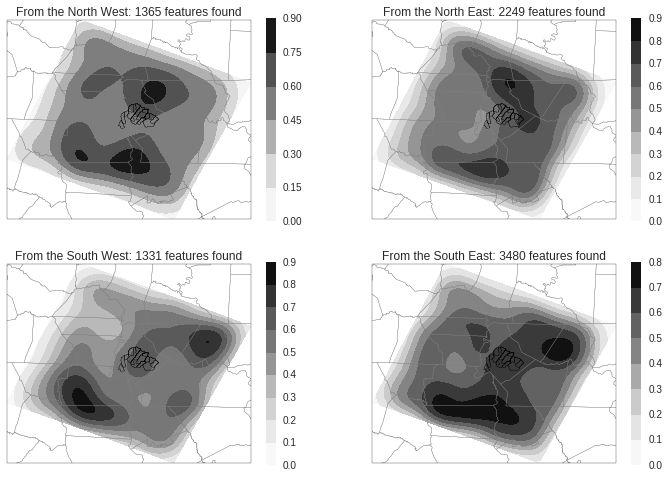

In [268]:
plt.figure(figsize=(12,8))
pos=False
neg=False
axes = []
for b in dirs4:
    ax = plt.subplot(2, 2, b[4], projection=ccrs.PlateCarree())
    ax.add_geometries(basins, ccrs.PlateCarree(), edgecolor='black', facecolor='None')
    ax.add_geometries(county, ccrs.PlateCarree(), edgecolor='gray', facecolor='None')

    lon, lat = get_lon_lat(b)
    if pos and not neg:
        cmap="PuRd"
    elif neg and not pos:
        cmap="PuBu"
    elif not neg and not pos:
        cmap="Greys"
    elif neg and pos:
        cmap=plt.cm.get_cmap("RdBu_r") 
    xx, yy, f = kde(lon, lat)    
    cfset = ax.contourf(xx, yy, f, cmap=cmap)

    ax.set_title('From the {direction}: {k} features found'.format(direction=b[2], k=lon.shape[0]))
    CB = plt.colorbar(cfset, ax=ax) 
    axes.append(ax)

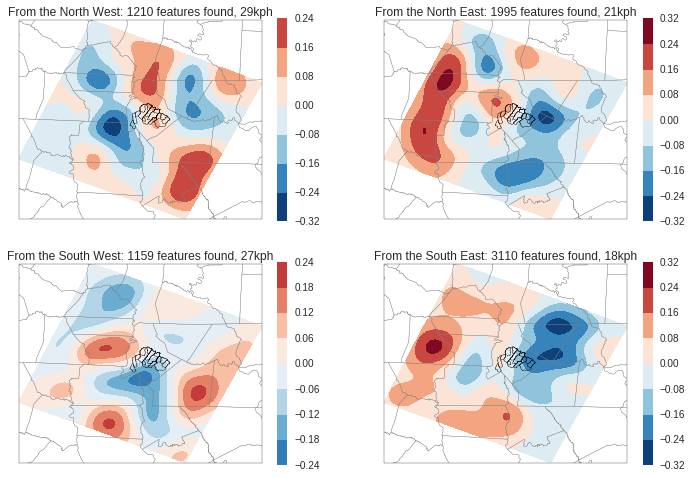

In [301]:
plt.figure(figsize=(12,8))
pos=True
neg=True
axes = []
for b in dirs4:
    ax = plt.subplot(2, 2, b[4], projection=ccrs.PlateCarree())
    ax.add_geometries(basins, ccrs.PlateCarree(), edgecolor='black', facecolor='None')
    ax.add_geometries(county, ccrs.PlateCarree(), edgecolor='gray', facecolor='None')
    #ax.set_extent(buffer_extent, ccrs.PlateCarree())
    pos_lon, pos_lat, neg_lon, neg_lat, dist = get_lon_lat(b, pos, neg, metrics=['area'])
    if pos and not neg:
        cmap="PuRd"
    elif neg and not pos:
        cmap="PuBu"
    elif not neg and not pos:
        cmap="BuGn"
    elif neg and pos:
        cmap=plt.cm.get_cmap("RdBu_r") 
    xx, yy, pos_f = kde(pos_lon, pos_lat)    
    xx, yy, neg_f = kde(neg_lon, neg_lat) 
    f = (pos_f-neg_f)
    flim = np.ceil(max(np.abs(f.min()), f.max()))
    cfset = ax.contourf(xx, yy, f, cmap=cmap, vmin=-.3, vmax=.3)
    #ax.scatter(pos_lon, pos_lat, c='black', s=5)
    ax.set_title('From the {direction}: {k} features found, {kph}kph'.format(direction=b[2], 
                                                                          k=pos_lon.shape[0]+neg_lon.shape[0], 
                                                                          kph=int(dist*4)))
    CB = plt.colorbar(cfset, ax=ax) 
    axes.append(ax)

plt.savefig('/home/jsignell/Paper/Notebooks/output/Binary KDE increase and decrease in area (4 dir).png')